# Summary:
This notebook will cover using **TfidfVectorizer** to convert texts to a matrix of token counts. Machine learning models **LogisticRegression**, **RandomForestClassifier** and **XGBClassifier** will then be applied to the count representation (sparse matrix) of texts.

# Table of contents
<br >&nbsp;&nbsp;&nbsp;[2.3 TfidfVectorizer](#Part2.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.1 LogisticRegression](#Part2.3.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.1.1 validation_curve](#Part2.3.1.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.1.2 GridSearchCV](#Part2.3.1.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.1.3 Model evaluation](#Part2.3.1.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.1.4 Feature importance](#Part2.3.1.4_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.2 RandomForestClassifier](#Part2.3.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.2.1 validation_curve](#Part2.3.2.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.2.2 GridSearchCV](#Part2.3.2.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.2.3 Model evaluation](#Part2.3.2.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.2.4 Feature importance](#Part2.3.2.4_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.3 XGBClassifier](#Part2.3.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.3.1 validation_curve](#Part2.3.3.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.3.2 GridSearchCV](#Part2.3.3.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.3.3 Model evaluation](#Part2.3.3.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.3.4 Feature importance](#Part2.3.3.4_link)

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib_venn import venn2
from collections import Counter
from collections import defaultdict
import time

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import gensim
from gensim.summarization.summarizer import summarize
from gensim.summarization import keywords
from matplotlib_venn import venn2
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from ast import literal_eval

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import itertools
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [2]:
base_dir='/Volumes/Yuchen_Drive/Personalized_Medicine'

Load preprocessed training files from the previous notebook.

In [3]:
train_df=pd.read_csv(os.path.join(base_dir,'pre/train_df_1.csv'))
test_df=pd.read_csv(os.path.join(base_dir,'pre/test_df_1.csv'))
train_df.head()

,ID,Text,Gene,Variation,Class,sent_length,word_length
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,FAM58A,Truncating Mutations,1,326,7313
1,1,Abstract Background Non-small cell lung canc...,CBL,W802*,2,248,6784
2,2,Abstract Background Non-small cell lung canc...,CBL,Q249E,2,248,6784
3,3,Recent evidence has demonstrated that acquired...,CBL,N454D,3,185,6396
4,4,Oncogenic mutations in the monomeric Casitas B...,CBL,L399V,4,262,7248


In [4]:
def preprocess(data):
    '''
    Credit goes to https://www.kaggle.com/gpreda/jigsaw-fast-compact-solution
    '''
    punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
    def clean_special_chars(text, punct):
        for p in punct:
            text = text.replace(p, ' ')
        return text

    data = data.astype(str).apply(lambda x: clean_special_chars(x, punct))
    return data

In [5]:
train_df['text_clean'] = preprocess(train_df.Text)
test_df['text_clean'] = preprocess(test_df.Text)

In [6]:
custom_words = ["fig", "figure", "et", "al", "al.", "also",
                "data", "analyze", "study", "table", "using",
                "method", "result", "conclusion", "author", 
                "find", "found", "show", '"', "’", "“", "”",
                "assayed", "assay", "assays","figures", "figure","data", "sample","samples","table","tables",
                'proteins','protein','cells','cell','genes','gene',
                'mutated','mutation','mutational','mutations','mutate','mutant','mutants',
                'cancer','cancers','tumor','tumors','variant','variants']
stop_word1 = gensim.parsing.preprocessing.STOPWORDS   ## 337
stop_word2 = nltk.corpus.stopwords.words('english')   ## 179
stop_words = set(list(stop_word1)+stop_word2+custom_words)   ## 433

In [7]:
bow_clean=list(train_df.text_clean)+list(test_df.text_clean)

<a id='Part2.3_link'></a>
## 2.3 TfidfVectorizer

**TFIDF: term frequency–inverse document frequency**
<br>Instead of using CountVectorizer to count the occurrence of each word, TfidfVectorizer can normalize the count of a word in a document against the number of documents in the corpus that contain the word. TFIDF can therefore reflect how important a word is to a document in the context of the entire corpus. 

In [8]:
tfidf_vectorizer=TfidfVectorizer(tokenizer=nltk.word_tokenize, stop_words=stop_words, analyzer='word', min_df=3, preprocessor=None, max_features=None)
tfidf_vectorizer.fit(bow_clean)
print('Total number of features in TfidfVectorizer: {}'.format(len(tfidf_vectorizer.get_feature_names())))   ## 157815

Total number of features in TfidfVectorizer: 157815


In [9]:
train_vec = tfidf_vectorizer.transform(train_df.text_clean)
print('train_vec.shape: {}'.format(train_vec.shape))

train_vec.shape: (3316, 157815)


<a id='Part2.3.1_link'></a>
### 2.3.1 LogisticRegression

<a id='Part2.3.1.1_link'></a>
### 2.3.1.1 validation_curve

1. **LogisticRegression** model hugely depends on data scaling. Before fitting the count vector directly to the LogisticRegression model, we can standardize features using **StandardScaler** from sklearn. In addition, since the count vector is a sparse matrix, `with_mean=False` needs to be specified. 

2. An important hyperparameter in LogisticRegression is 
<br>**C**: Inverse of regularization strength, smaller values specify stronger regularization.

3. To evaluate how model performs in both training and validation datasets, we can use **validation_curve** from sklearn to plot training and test scores for different values of a single hyperparameter. Here I will plot the training and test scores of **LogisticRegression** across different **C** values.

In [17]:
def plot_val_curve(train_scores,test_scores,param_name, param_vals,title,logx=True):
    train_mean = train_scores.mean(axis=1).values
    print('{}: {}'.format(param_name, param_vals))
    print('train_mean: {}'.format(train_mean))
    train_std = train_scores.std(axis=1).values
    test_mean = test_scores.mean(axis=1).values
    print('test_mean: {}'.format(test_mean))
    print('-'*80)
    print('{}: {} achieves highest test score: {}'.format(param_name,param_vals[np.argmax(test_mean)], test_mean.max()))
    print('-'*80)
    test_std = test_scores.std(axis=1).values
    fig,ax=plt.subplots(1,1,figsize = (12,5))
    plt.title(title,fontsize=18)
    if logx:
        plt.semilogx(param_vals, train_mean, 'o-', color = 'r', label = 'Training Score')
        plt.semilogx(param_vals, test_mean, 'o-', color = 'b', label = 'Validation Score')
    else:
        plt.plot(param_vals, train_mean, 'o-', color = 'r', label = 'Training Score')
        plt.plot(param_vals, test_mean, 'o-', color = 'b', label = 'Validation Score')
    plt.fill_between(param_vals, train_mean-train_std, train_mean+train_std, alpha = 0.15, color = 'r')
    plt.fill_between(param_vals, test_mean-train_std, test_mean+test_std, alpha = 0.15, color = 'b')
    plt.legend(loc = 'lower right')
    plt.xlabel('{}'.format(param_name),fontsize=12)
    plt.ylabel('Score',fontsize=12)
    plt.ylim([-0.05,1.05])
    ax.vlines(param_vals[np.argmax(test_mean)], -0.05, 1.05, linestyles='-.', color = sns.xkcd_rgb["pale red"])
    plt.show()

* Model: StandardScaler + LogisticRegression

In [ ]:
ss = StandardScaler(with_mean=False)
X=ss.fit_transform(train_vec)
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
c_vals=np.logspace(-5,3,12)
train_scores, test_scores = validation_curve(LogisticRegression(n_jobs=-1,random_state=8), X, y, param_name = 'C', param_range = c_vals, cv = cv, scoring = 'accuracy')

In [24]:
## Models were trained in HPC and output scores are uploaded here.
## Personalized_Medicine_TfidfVectorizer_LogisticRegression_C_ss.py
train_scores=pd.read_csv(os.path.join(base_dir,'ml_result/Personalized_Medicine_TfidfVectorizer_LogisticRegression_C_ss_train_scores_df.csv'))
test_scores=pd.read_csv(os.path.join(base_dir,'ml_result/Personalized_Medicine_TfidfVectorizer_LogisticRegression_C_ss_test_scores_df.csv'))

C: [1.00000000e-05 5.33669923e-05 2.84803587e-04 1.51991108e-03
 8.11130831e-03 4.32876128e-02 2.31012970e-01 1.23284674e+00
 6.57933225e+00 3.51119173e+01 1.87381742e+02 1.00000000e+03]
train_mean: [0.83496369 0.86987058 0.87989658 0.88411905 0.88577792 0.88540068
 0.88532575 0.88623092 0.88811726 0.88841781 0.88917213 0.88969938]
test_mean: [0.40036677 0.41090188 0.42024073 0.4277524  0.42864694 0.4319503
 0.43165315 0.4202314  0.39728727 0.38007722 0.37163014 0.37166699]
--------------------------------------------------------------------------------
C: 0.043287612810830614 achieves highest test score: 0.43195030235079634
--------------------------------------------------------------------------------


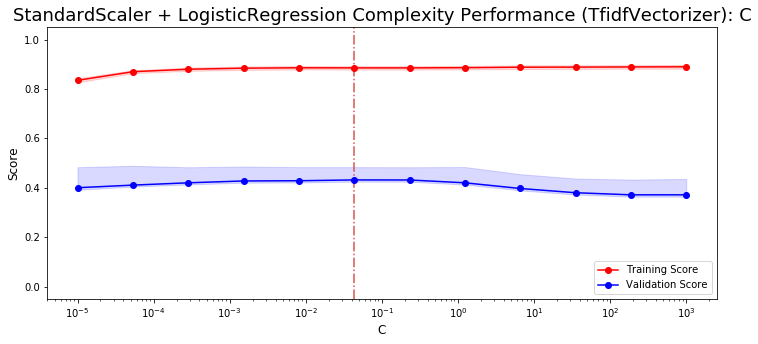

In [25]:
c_vals=np.logspace(-5,3,12)
title='StandardScaler + LogisticRegression Complexity Performance (TfidfVectorizer): C'
plot_val_curve(train_scores,test_scores,'C', c_vals,title,logx=True)

<a id='Part2.3.1.2_link'></a>
### 2.3.1.2 GridSearchCV

Two hyperparameters will be tested in **GridSearchCV** from sklearn to find the best values for **LogisticRegression**:
1. **C**: Inverse of regularization strength, smaller values specify stronger regularization.
2. **class_weight**: Since the 9 classes in the training dataset is not balanced. To avoid bias in model training, class_weight may need to be added to the model.

* Model: StandardScaler + LogisticRegression

In [12]:
pl = Pipeline([('ss', StandardScaler(with_mean=False)),
               ('lr', LogisticRegression(n_jobs=-1,random_state=8))])

In [ ]:
## Models were trained in HPC and output scores are uploaded here.
## Personalized_Medicine_TfidfVectorizer_LogisticRegression_ss_gridsearch1.py
X=train_vec
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
params={"lr__C":[0.001,0.005,0.008,0.01,0.02,0.03,0.04,0.05],
        "lr__class_weight":[None,{1:1,2:1,3:2,4:1,5:2,6:2,7:1,8:2,9:2}]}
clf=GridSearchCV(pl, param_grid=params, cv=cv, scoring = 'accuracy',return_train_score=True)
clf.fit(X, y)
pd.DataFrame.from_dict(clf.cv_results_).to_csv(os.path.join(base_dir,'ml_result3/Personalized_Medicine_TfidfVectorizer_LogisticRegression_ss_gridsearch1.csv'),index=False)

In [15]:
cv_results=pd.read_csv(os.path.join(base_dir,'ml_result3/Personalized_Medicine_TfidfVectorizer_LogisticRegression_ss_gridsearch1.csv'))
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__C,param_lr__class_weight,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,25.832524,0.721837,0.030818,0.003031,0.001,NaN,"{'lr__C': 0.001, 'lr__class_weight': None}",0.383234,0.303303,0.361027,...,0.385404,0.056147,1,0.873489,0.887170,0.892238,0.880979,0.883703,0.883516,0.006268
1,27.652157,1.000077,0.030850,0.002579,0.001,"{1: 1, 2: 1, 3: 2, 4: 1, 5: 2, 6: 2, 7: 1, 8: ...","{'lr__C': 0.001, 'lr__class_weight': {1: 1, 2:...",0.386228,0.300300,0.358006,...,0.383595,0.056922,6,0.872356,0.884906,0.889601,0.878343,0.881445,0.881330,0.005842
2,42.880777,1.906725,0.031781,0.001819,0.005,NaN,"{'lr__C': 0.005, 'lr__class_weight': None}",0.383234,0.303303,0.356495,...,0.383595,0.055873,6,0.875000,0.889434,0.893745,0.882109,0.885209,0.885099,0.006395
3,44.717715,1.160916,0.030085,0.002366,0.005,"{1: 1, 2: 1, 3: 2, 4: 1, 5: 2, 6: 2, 7: 1, 8: ...","{'lr__C': 0.005, 'lr__class_weight': {1: 1, 2:...",0.384731,0.301802,0.356495,...,0.382992,0.056125,13,0.873867,0.887547,0.890731,0.879096,0.882574,0.882763,0.005983
4,48.548779,2.198865,0.031145,0.001956,0.008,NaN,"{'lr__C': 0.008, 'lr__class_weight': None}",0.383234,0.301802,0.356495,...,0.383595,0.057186,6,0.875378,0.889434,0.893745,0.882486,0.886338,0.885476,0.006256


In [ ]:
print("lr__C: {}".format(clf.best_estimator_.get_params()['lr__C']))
print("lr__class_weight: {}".format(clf.best_estimator_.get_params()['lr__class_weight']))

lr__C: 0.001
<br>lr__class_weight: None

<a id='Part2.3.1.3_link'></a>
### 2.3.1.3 Model evaluation

Here are some functions used in model evaluation.

In [20]:
def model_eval(clf, X, y):
    cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
    probas = cross_val_predict(clf, X, y, cv=cv, n_jobs=-1, method='predict_proba', verbose=2)
    pred_indices = np.argmax(probas, axis=1)
    preds=np.unique(y)[pred_indices]
    accuracy = accuracy_score(y, preds)
    logloss = log_loss(y, probas)
    print('accuracy score: {}'.format(accuracy))
    print('log_loss: {}'.format(logloss))
    output = pd.DataFrame(probas,columns=['Class{}'.format(i) for i in range(1,10)])
    output['pred']=preds
    return output

In [21]:
def plot_confusion_matrix(cm, classes,title='Confusion matrix',cmap=plt.cm.Blues):    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar(shrink=0.8)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12, fontweight='bold')
    plt.yticks(tick_marks, classes, fontsize=12, fontweight='bold')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:d} \n({:.2f}%)'.format(cm[i, j], cm[i,j]/cm.sum()*100), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    plt.tight_layout()

In [22]:
def plot_acc_bar(cm,total_acc):
    acc=[cm[i][i] for i in range(len(classes))]
    acc_freq=acc/cm.sum(axis=1)
    fig = plt.figure(figsize = (20,8))
    ax = fig.add_subplot(1,1,1)
    width = 0.75 # the width of the bars 
    ind = np.arange(len(classes))  # the x locations for the groups
    ax.bar(ind, np.round(acc_freq*100,2), width, edgecolor='black', color = sns.color_palette('hls', len(classes)))
    plt.xticks(ind, labels = classes, fontsize=18, fontweight='bold', rotation=45)
    plt.yticks(fontsize=16)
    plt.xlabel('Category', fontsize=18)
    plt.ylabel('Accuracy%', fontsize=18)
    for i, v in enumerate(np.round(acc_freq*100,2)):
        ax.text(i-0.25, v + 1, str(np.round(v,2))+'%', fontweight='bold', fontsize=18)
        ax.plot([-0.5, 8.5], [total_acc, total_acc], "k--", linewidth=2)
    ax.text(8.5, total_acc, 'Avg:\n'+str(total_acc)+'%', fontweight='bold', fontsize=18)

In [23]:
def plot_ROC_curve(acc_df):
    probas=np.array(acc_df.drop(['pred'],axis=1))

    fpr = dict()
    tpr = dict()
    auc_list = []
    label_to_class_dict = {i:l for i,l in enumerate(classes)}
    for i in np.arange(len(classes)):
        true_label_array = (y == i+1).astype(np.uint8)
        probs = probas[:,i]
        fpr[i], tpr[i], _ = roc_curve(true_label_array, probs)
        auc_value = auc(fpr[i], tpr[i])
        auc_list.append(auc_value)

    palette=sns.color_palette('hls',len(classes))
    for i in np.arange(len(classes)):
        plt.plot(fpr[i], tpr[i], color = palette[i], label='{} (area = {:.2f})'.format(classes[i], auc_list[i]))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

* Model: StandardScaler + LogisticRegression(C=0.001)

In [26]:
X=train_vec
y=train_df.Class.values

pl = Pipeline([('ss', StandardScaler(with_mean=False)),
               ('lr', LogisticRegression(C=0.001,n_jobs=-1,random_state=8))])

In [27]:
output=model_eval(pl, X, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   39.1s remaining:   58.6s


accuracy score: 0.3854041013268999
log_loss: 2.419069517642805


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   40.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   40.2s finished


In [28]:
output.head()

,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9,pred
0,0.004115,0.005315,0.007428,0.006442,0.005149,0.005539,0.953753,0.006136,0.006123,7
1,0.028471,0.032366,0.007626,0.508231,0.008070,0.025173,0.378217,0.005680,0.006166,4
2,0.028471,0.032366,0.007626,0.508231,0.008070,0.025173,0.378217,0.005680,0.006166,4
3,0.155754,0.094386,0.008048,0.074325,0.015687,0.016009,0.621598,0.006375,0.007817,7
4,0.189856,0.055717,0.028300,0.191600,0.023079,0.083694,0.403732,0.010399,0.013624,7


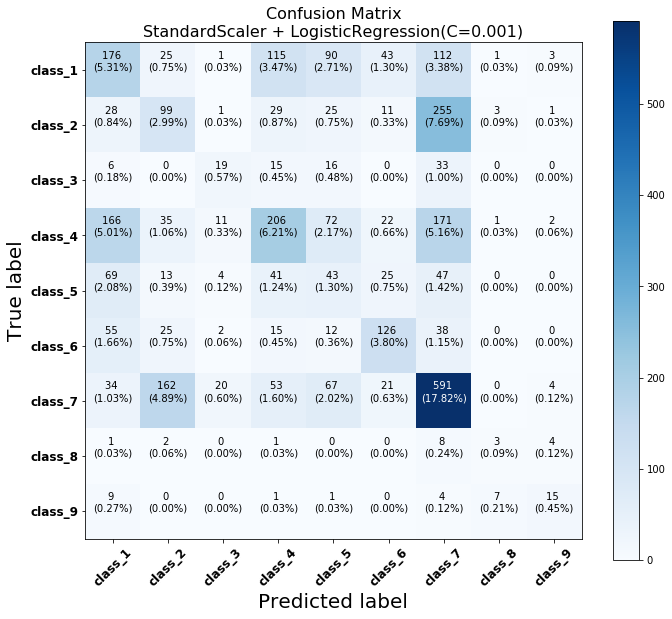

In [29]:
cm = confusion_matrix(train_df.Class.values, output.pred)
classes = ['class_{}'.format(i) for i in range(1,10)]
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix\nStandardScaler + LogisticRegression(C=0.001)', cmap=plt.cm.Blues)

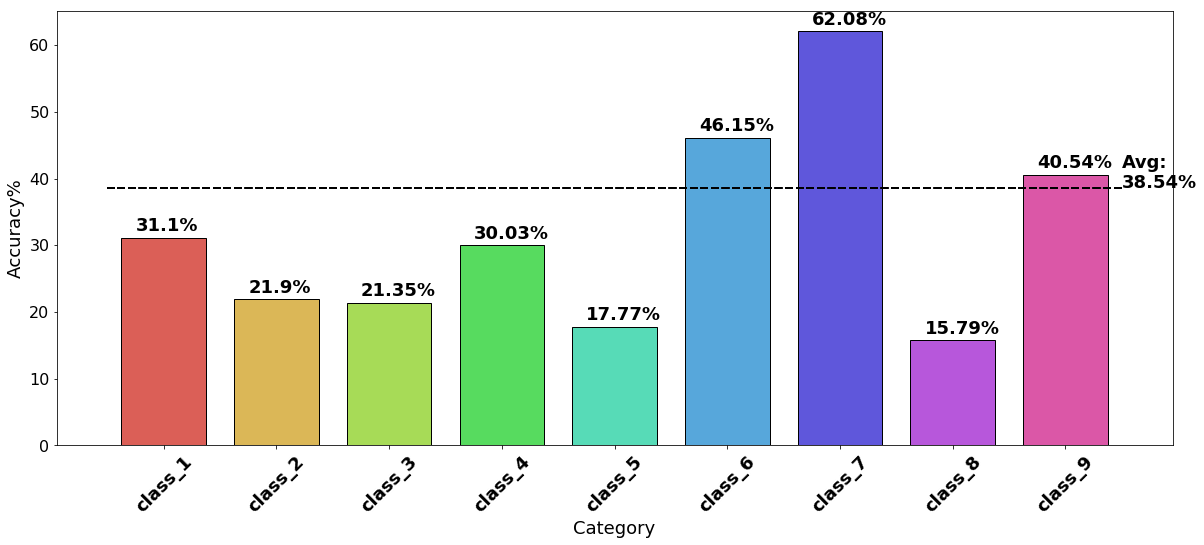

In [30]:
plot_acc_bar(cm,total_acc=38.54)

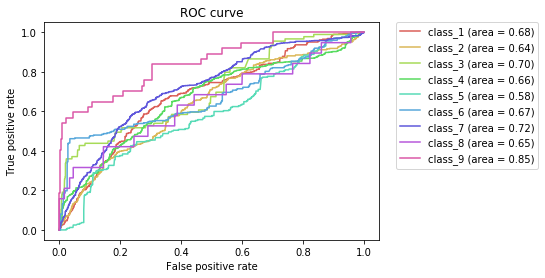

In [31]:
plot_ROC_curve(output)

<a id='Part2.3.1.4_link'></a>
### 2.3.1.4 Feature importance

We can extract the features (words) with highest/smallest coefficients from the trained model for each class.

In [32]:
def extract_feature_importance(model, vectorizer,num):
    '''
    Extract features with largest/smallest coefs from the 
    trained model based on vectorizer for each class
    '''
    index_to_word={v:k for k,v in vectorizer.vocabulary_.items()}
    output={}
    for idx in range(model.coef_.shape[0]):
        output[idx]={}
        word_importances=[(v,index_to_word[i]) for i,v in enumerate(model.coef_[idx])]
        word_importances_sorted=sorted(word_importances,key=lambda x:x[0],reverse=True)
        tops=word_importances_sorted[:num]
        bottoms=word_importances_sorted[-num:]
        output[idx]=tops+bottoms
    return output

In [33]:
def plot_feature_importance(feature_df,num):
    palette=sns.color_palette('RdBu',20)
    fig,axes=plt.subplots(3,3,figsize=(12,12))
    for i in range(len(output)):
        nrow=i//3
        ncol=i%3
        data_df=pd.DataFrame.from_records(output[i],columns=['coef','words'])
        sns.barplot(x='words',y='coef',data=data_df,palette=palette,ax=axes[nrow][ncol],edgecolor='black')
        axes[nrow][ncol].set_title('Class{}'.format(i+1))
        axes[nrow][ncol].set_xticklabels(np.array(data_df.words),rotation=90)
    plt.tight_layout()

* Model: StandardScaler + LogisticRegression(C=0.001)

In [34]:
ss=StandardScaler(with_mean=False)
X=ss.fit_transform(train_vec)
y=train_df.Class.values
clf=LogisticRegression(C=0.001,n_jobs=-1,random_state=8)
clf.fit(X,y)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=8,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)

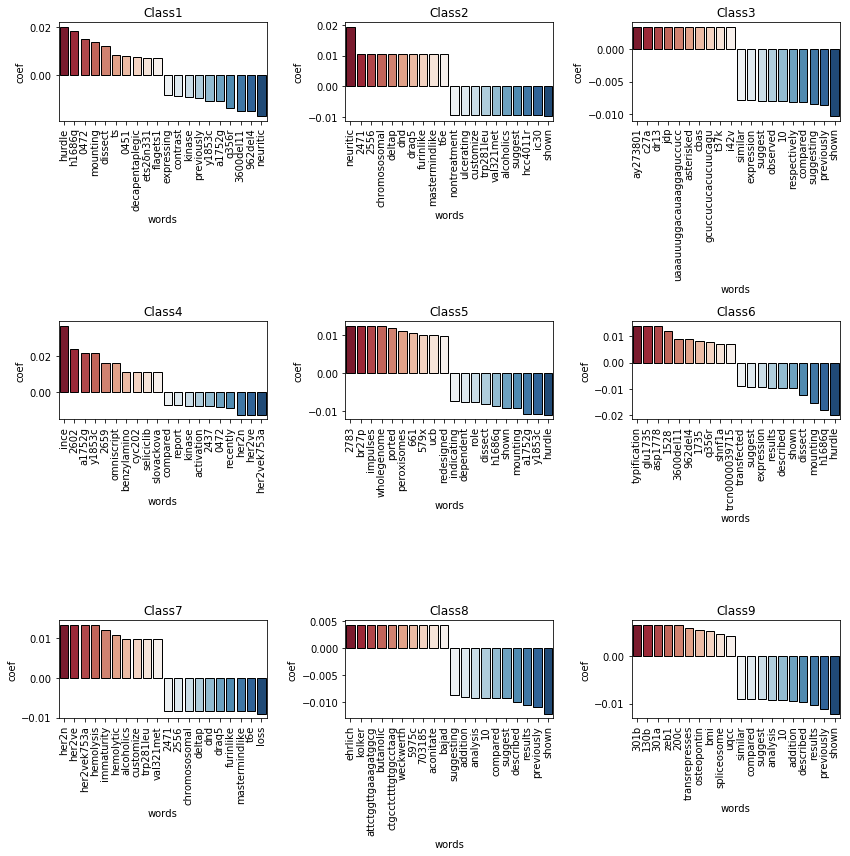

In [36]:
output=extract_feature_importance(clf, tfidf_vectorizer,num=10)
plot_feature_importance(output,num=10)

**Conclusion for LogisticRegression**: 
<br>StandardScaler + LogisticRegression(C=0.001) achieves the highest accuracy score of 0.39. There is overall overfitting using this model.

<a id='Part2.3.2_link'></a>
### 2.3.2 RandomForestClassifier

<a id='Part2.3.2.1_link'></a>
### 2.3.2.1 validation_curve

Several important hyperparameters for **RandomForestClassifier**:
1. **n_estimators** (default=100): The number of trees in the forest.
2. **max_depth** (default=None): The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
3. **min_samples_leaf** (default=1): The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches.

* Model: RandomForestClassifier

In [ ]:
X=train_vec
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
n_estimators=np.array([100,150,200,500,1000,2000])
train_scores, test_scores = validation_curve(RandomForestClassifier(n_jobs=-1,random_state=8), X, y, param_name = 'n_estimators', param_range = n_estimators, cv = cv, scoring = 'accuracy')

In [37]:
## Models were trained in HPC and output scores are uploaded here.
## Personalized_Medicine_TfidfVectorizer_RandomForestClassifier_nestimators.py
train_scores=pd.read_csv(os.path.join(base_dir,'ml_result/Personalized_Medicine_TfidfVectorizer_RandomForestClassifier_nestimators_train_scores_df.csv'))
test_scores=pd.read_csv(os.path.join(base_dir,'ml_result/Personalized_Medicine_TfidfVectorizer_RandomForestClassifier_nestimators_test_scores_df.csv'))

n_estimators: [ 100  150  200  500 1000 2000]
train_mean: [0.90335005 0.90335005 0.90335005 0.90335005 0.90335005 0.90335005]
test_mean: [0.46969631 0.46942924 0.47361848 0.47778824 0.46910039 0.4745168 ]
--------------------------------------------------------------------------------
n_estimators: 500 achieves highest test score: 0.47778824142519366
--------------------------------------------------------------------------------


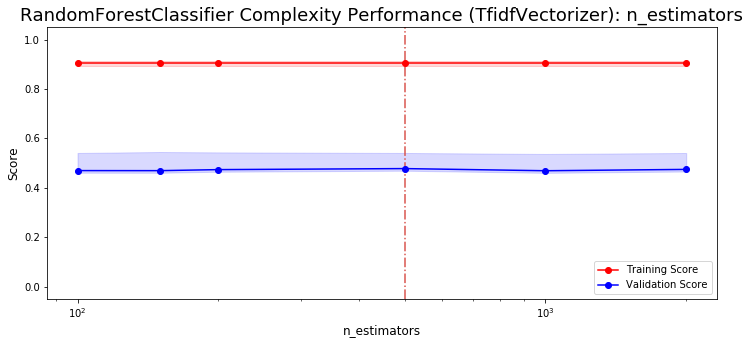

In [38]:
n_estimators=np.array([100,150,200,500,1000,2000])
title='RandomForestClassifier Complexity Performance (TfidfVectorizer): n_estimators'
plot_val_curve(train_scores,test_scores,'n_estimators', n_estimators,title,logx=True)

In [ ]:
X=train_vec
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
n_estimators=np.array([100,150,200,500,1000,2000])
train_scores, test_scores = validation_curve(RandomForestClassifier(n_jobs=-1,random_state=8), X, y, param_name = 'max_depth', param_range = max_depth, cv = cv, scoring = 'accuracy')

In [39]:
## Models were trained in HPC and output scores are uploaded here.
## Personalized_Medicine_TfidfVectorizer_RandomForestClassifier_maxdepth.py
train_scores=pd.read_csv(os.path.join(base_dir,'ml_result/Personalized_Medicine_TfidfVectorizer_RandomForestClassifier_maxdepth_train_scores_df.csv'))
test_scores=pd.read_csv(os.path.join(base_dir,'ml_result/Personalized_Medicine_TfidfVectorizer_RandomForestClassifier_maxdepth_test_scores_df.csv'))

max_depth: [    5    10    20    50   100   500  1000 10000]
train_mean: [0.5135592  0.70528101 0.87123234 0.8973946  0.89716824 0.89716824
 0.89716824 0.89716824]
test_mean: [0.40470247 0.43352348 0.43175162 0.4488038  0.44730357 0.44730357
 0.44730357 0.44730357]
--------------------------------------------------------------------------------
max_depth: 50 achieves highest test score: 0.4488037984173016
--------------------------------------------------------------------------------


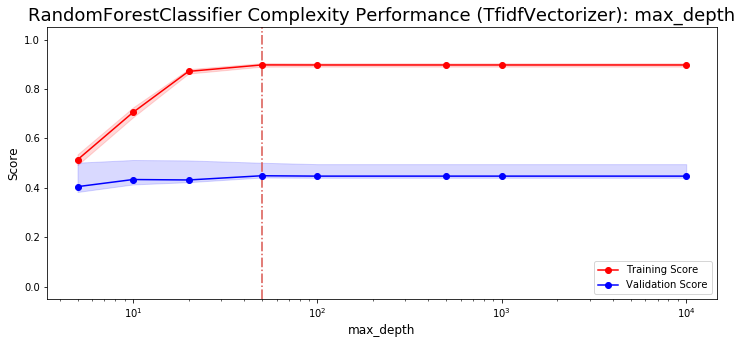

In [40]:
max_depth=np.array([5,10,20,50,100,500,1000,10000])
title='RandomForestClassifier Complexity Performance (TfidfVectorizer): max_depth'
plot_val_curve(train_scores,test_scores,'max_depth', max_depth,title,logx=True)

In [ ]:
X=train_vec
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
min_samples_leaf=np.array([1,5,15,100,300,500])
train_scores, test_scores = validation_curve(RandomForestClassifier(n_jobs=-1,random_state=8), X, y, param_name = 'min_samples_leaf', param_range = min_samples_leaf, cv = cv, scoring = 'accuracy')

In [42]:
## Models were trained in HPC and output scores are uploaded here.
## Personalized_Medicine_TfidfVectorizer_RandomForestClassifier_minsamplesleaf.py
train_scores=pd.read_csv(os.path.join(base_dir,'ml_result/Personalized_Medicine_TfidfVectorizer_RandomForestClassifier_minsamplesleaf_train_scores_df.csv'))
test_scores=pd.read_csv(os.path.join(base_dir,'ml_result/Personalized_Medicine_TfidfVectorizer_RandomForestClassifier_minsamplesleaf_test_scores_df.csv'))

min_samples_leaf: [  1   5  15 100 300 500]
train_mean: [0.89716824 0.80451466 0.69082021 0.49353744 0.35924649 0.32004019]
test_mean: [0.44730357 0.45002796 0.42659979 0.3981485  0.30880746 0.3019159 ]
--------------------------------------------------------------------------------
min_samples_leaf: 5 achieves highest test score: 0.45002796207231743
--------------------------------------------------------------------------------


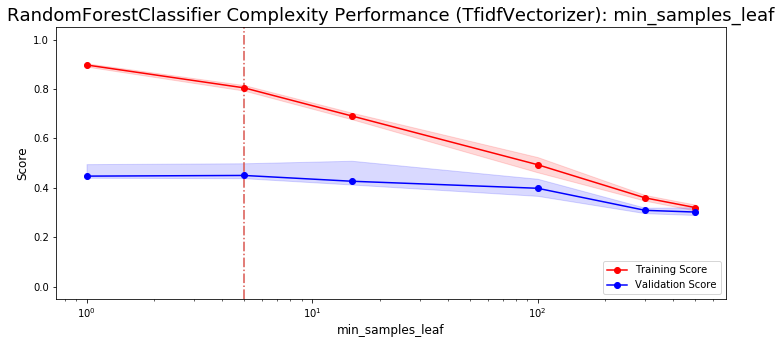

In [43]:
min_samples_leaf=np.array([1,5,15,100,300,500])
title='RandomForestClassifier Complexity Performance (TfidfVectorizer): min_samples_leaf'
plot_val_curve(train_scores,test_scores,'min_samples_leaf', min_samples_leaf,title,logx=True)

**Conclusion**:
1. **n_estimators** (default=100): The number of trees in the forest generally doesn't affect training/validation score.
2. **max_depth** (default=None): The maximum depth of the tree. Larger max_depth leads to increased training score and overfitting.
3. **min_samples_leaf** (default=1): The minimum number of samples required to be at a leaf node. Smaller min_samples_leaf leads to increased training score and overfitting.

<a id='Part2.3.2.2_link'></a>
### 2.3.2.2 GridSearchCV

To further finetune the best values for hyperparameters, I will use **GridSearchCV** from sklearn.

In [ ]:
## Models were trained in HPC and output scores are uploaded here.
## Personalized_Medicine_TfidfVectorizer_RandomForestClassifier_gridsearch1.py
rf=RandomForestClassifier(n_jobs=-1,random_state=8)
X=train_vec
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
params={"n_estimators":[200,500,1000],
        "max_depth":[10,20,50,None],
        "min_samples_leaf":[1,5,15]}
clf=GridSearchCV(rf, param_grid=params, cv=cv, scoring = 'accuracy',return_train_score=True)
clf.fit(X, y)

In [ ]:
print("n_estimators: {}".format(clf.best_estimator_.get_params()['n_estimators']))
print("max_depth: {}".format(clf.best_estimator_.get_params()['max_depth']))
print("min_samples_leaf: {}".format(clf.best_estimator_.get_params()['min_samples_leaf']))

n_estimators: 500
<br>max_depth: 20
<br>min_samples_leaf: 1

In [57]:
cv_results=pd.read_csv(os.path.join(base_dir,'ml_result3/Personalized_Medicine_TfidfVectorizer_RandomForestClassifier_gridsearch1.csv'))
cv_results[(cv_results.param_n_estimators==500) & (cv_results.param_max_depth==20)]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
10,891.502058,100.526840,3.841986,0.311289,20.0,1,500,"{'max_depth': 20, 'min_samples_leaf': 1, 'n_es...",0.432635,0.475976,...,0.482811,0.056588,1,0.894637,0.908679,0.908063,0.893785,0.891231,0.899279,0.007510
13,84.895369,6.755626,4.341993,0.294011,20.0,5,500,"{'max_depth': 20, 'min_samples_leaf': 5, 'n_es...",0.434132,0.450450,...,0.478287,0.057902,5,0.824396,0.833585,0.832329,0.821469,0.828378,0.828031,0.004598
16,15.133705,1.834791,4.291938,0.287121,20.0,15,500,"{'max_depth': 20, 'min_samples_leaf': 15, 'n_e...",0.407186,0.450450,...,0.465923,0.068808,19,0.712236,0.726415,0.723060,0.706968,0.724878,0.718711,0.007696


<a id='Part2.3.2.3_link'></a>
### 2.3.2.3 Model evaluation

* Model: RandomForestClassifier(n_estimators=500,max_depth=20,min_samples_leaf=1)

In [58]:
X=train_vec
y=train_df.Class.values
clf=RandomForestClassifier(n_estimators=500,max_depth=20,min_samples_leaf=1,n_jobs=-1,random_state=8)

In [59]:
output=model_eval(clf, X, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 12.0min remaining: 18.1min


accuracy score: 0.482810615199035
log_loss: 1.597799361218187


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 12.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 12.6min finished


In [60]:
output.head()

,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9,pred
0,0.220032,0.139142,0.012798,0.307260,0.036387,0.021177,0.243314,0.006305,0.013585,4
1,0.177689,0.165141,0.010522,0.180402,0.035578,0.029635,0.373276,0.014937,0.012820,7
2,0.177689,0.165141,0.010522,0.180402,0.035578,0.029635,0.373276,0.014937,0.012820,7
3,0.159190,0.195647,0.011179,0.153263,0.035584,0.031206,0.395099,0.004346,0.014485,7
4,0.211765,0.146557,0.013258,0.210030,0.055293,0.044879,0.297348,0.010665,0.010206,7


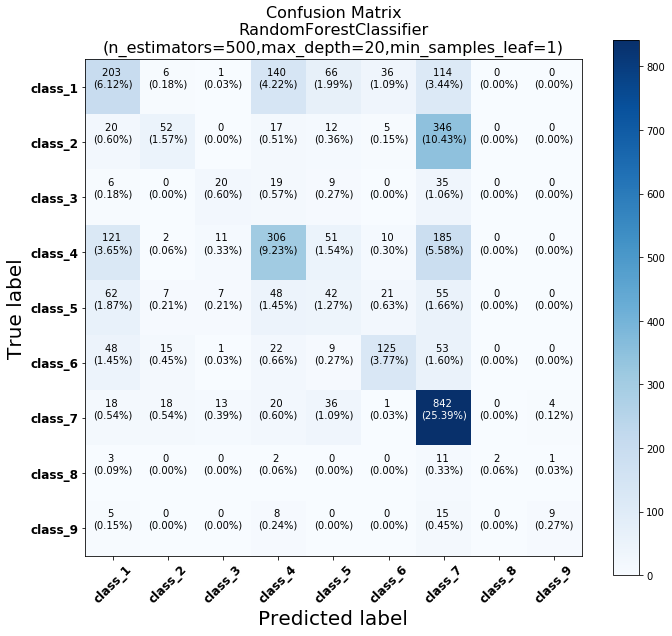

In [61]:
cm = confusion_matrix(train_df.Class.values, output.pred)
classes = ['class_{}'.format(i) for i in range(1,10)]
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix\nRandomForestClassifier\n(n_estimators=500,max_depth=20,min_samples_leaf=1)', cmap=plt.cm.Blues)

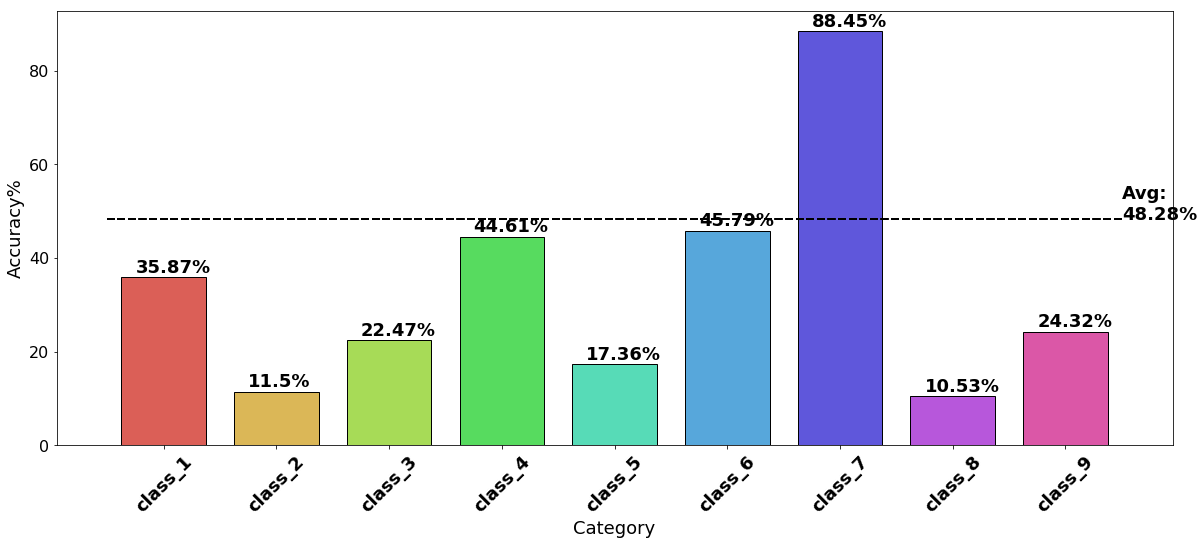

In [62]:
plot_acc_bar(cm,total_acc=48.28)

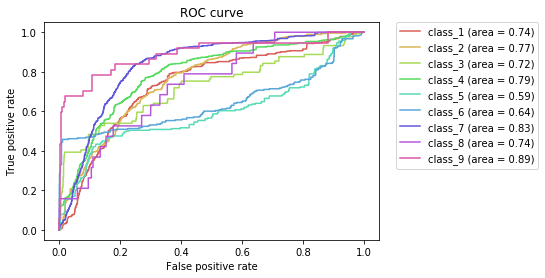

In [63]:
plot_ROC_curve(output)

<a id='Part2.3.2.4_link'></a>
### 2.3.2.4 Feature importance

We can extract the features (words) with high importance from the trained model.

* Model: RandomForestClassifier(n_estimators=500,max_depth=20,min_samples_leaf=1)

In [64]:
X=train_vec
y=train_df.Class.values
clf=RandomForestClassifier(n_estimators=500,max_depth=20,min_samples_leaf=1,n_jobs=-1,random_state=8)
clf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)

In [65]:
def extract_feature_importance_rf(model, vectorizer, n=20):
    '''
    Extract features with high importance from the trained model based on vectorizer
    '''
    index_to_word={v:k for k,v in vectorizer.vocabulary_.items()}
    word_importances=[(index_to_word[i], v) for i,v in enumerate(model.feature_importances_)]
    word_importances_sorted=sorted(word_importances,key=lambda x:x[1],reverse=True)
    tops=word_importances_sorted[:10]
    output=pd.DataFrame.from_records(tops,columns=['words','importance'])
    return output

In [66]:
top_features=extract_feature_importance_rf(clf,tfidf_vectorizer,n=20)
top_features

,words,importance
0,kinase,0.002612
1,activating,0.002591
2,inhibitor,0.001918
3,signaling,0.001857
4,activation,0.001847
5,tyrosine,0.001724
6,treated,0.001693
7,treatment,0.001628
8,inhibitors,0.001628
9,oncogenic,0.001622


**Conclusion for RandomForestClassifier**: 
<br>RandomForestClassifier(n_estimators=500,max_depth=20,min_samples_leaf=1) achieves the highest accuracy score of 0.48.

<a id='Part2.3.3_link'></a>
### 2.3.3 XGBClassifier

<a id='Part2.3.3.1_link'></a>
### 2.3.3.1 validation_curve

https://xgboost.readthedocs.io/en/latest/parameter.html
<br>Important hyperparameters for **XGBClassifier**:
1. **eta** (learning_rate, default=0.3)
2. **gamma** (default=0): Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.
3. **max_depth** (default=6): Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
4. **min_child_weight** (default=1): Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning.
5. **colsample_bytree** (default=1): The subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.

* Model: XGBClassifier

In [ ]:
X=train_vec
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
max_depth=np.array([5,6,10,20,50,100,500,1000])
train_scores, test_scores = validation_curve(XGBClassifier(), X, y, param_name = 'max_depth', param_range = max_depth, cv = cv, scoring = 'accuracy')

In [46]:
## Models were trained in HPC and output scores are uploaded here.
## Personalized_Medicine_TfidfVectorizer_XGBClassifier_maxdepth.py
train_scores=pd.read_csv(os.path.join(base_dir,'ml_result/Personalized_Medicine_TfidfVectorizer_XGBClassifier_maxdepth_train_scores_df.csv'))
test_scores=pd.read_csv(os.path.join(base_dir,'ml_result/Personalized_Medicine_TfidfVectorizer_XGBClassifier_maxdepth_test_scores_df.csv'))

max_depth: [   5    6   10   20   50  100  500 1000]
train_mean: [0.90319905 0.90335005 0.90335005 0.90335005 0.90335005 0.90335005
 0.90335005 0.90335005]
test_mean: [0.47837835 0.48045663 0.47593547 0.47084706 0.47233488 0.4780708
 0.4780708  0.4780708 ]
--------------------------------------------------------------------------------
max_depth: 6 achieves highest test score: 0.48045663416146994
--------------------------------------------------------------------------------


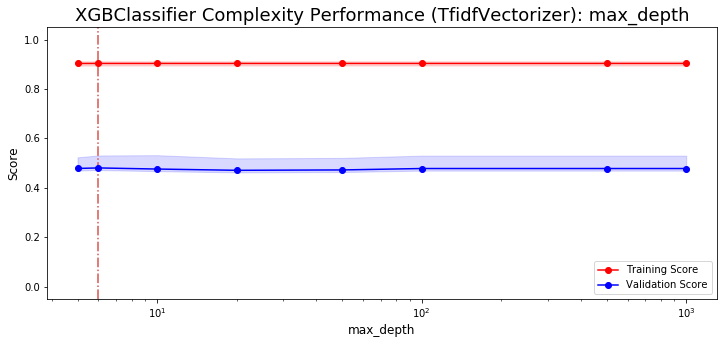

In [47]:
max_depth=np.array([5,6,10,20,50,100,500,1000])
title='XGBClassifier Complexity Performance (TfidfVectorizer): max_depth'
plot_val_curve(train_scores,test_scores,'max_depth', max_depth,title,logx=True)

In [ ]:
X=train_vec
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
min_child_weight=np.array([1, 3, 5, 8, 10, 20])
train_scores, test_scores = validation_curve(XGBClassifier(), X, y, param_name = 'min_child_weight', param_range = min_child_weight, cv = cv, scoring = 'accuracy')

In [48]:
## Models were trained in HPC and output scores are uploaded here.
## Personalized_Medicine_TfidfVectorizer_XGBClassifier_minchildweight.py
train_scores=pd.read_csv(os.path.join(base_dir,'ml_result/Personalized_Medicine_TfidfVectorizer_XGBClassifier_minchildweight_train_scores_df.csv'))
test_scores=pd.read_csv(os.path.join(base_dir,'ml_result/Personalized_Medicine_TfidfVectorizer_XGBClassifier_minchildweight_test_scores_df.csv'))

min_child_weight: [ 1  3  5  8 10 20]
train_mean: [0.87967617 0.87628363 0.87160888 0.86542537 0.8618828  0.84619986]
test_mean: [0.49157096 0.49217093 0.49792988 0.49190749 0.49762996 0.49131856]
--------------------------------------------------------------------------------
min_child_weight: 5 achieves highest test score: 0.49792988080629
--------------------------------------------------------------------------------


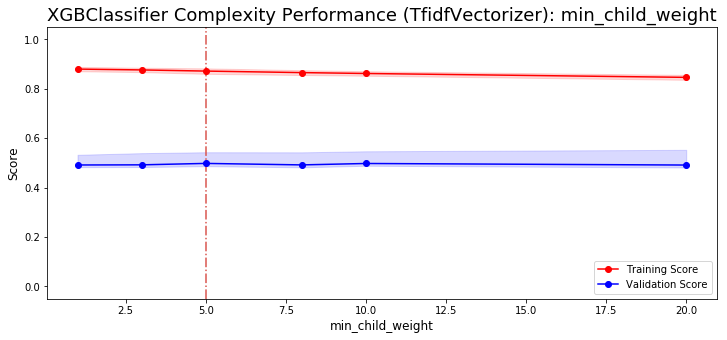

In [49]:
min_child_weight=np.array([1, 3, 5, 8, 10, 20])
title='XGBClassifier Complexity Performance (TfidfVectorizer): min_child_weight'
plot_val_curve(train_scores,test_scores,'min_child_weight', min_child_weight,title,logx=False)

In [ ]:
X=train_vec
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
eta=np.array([0.05, 0.10, 0.15, 0.20, 0.25, 0.30])
train_scores, test_scores = validation_curve(XGBClassifier(), X, y, param_name = 'eta', param_range = eta, cv = cv, scoring = 'accuracy')

In [50]:
## Models were trained in HPC and output scores are uploaded here.
## Personalized_Medicine_TfidfVectorizer_XGBClassifier_eta.py
train_scores=pd.read_csv(os.path.join(base_dir,'ml_result/Personalized_Medicine_TfidfVectorizer_XGBClassifier_eta_train_scores_df.csv'))
test_scores=pd.read_csv(os.path.join(base_dir,'ml_result/Personalized_Medicine_TfidfVectorizer_XGBClassifier_eta_test_scores_df.csv'))

eta: [0.05 0.1  0.15 0.2  0.25 0.3 ]
train_mean: [0.87967617 0.87967617 0.87967617 0.87967617 0.87967617 0.87967617]
test_mean: [0.49157096 0.49157096 0.49157096 0.49157096 0.49157096 0.49157096]
--------------------------------------------------------------------------------
eta: 0.05 achieves highest test score: 0.4915709558707871
--------------------------------------------------------------------------------


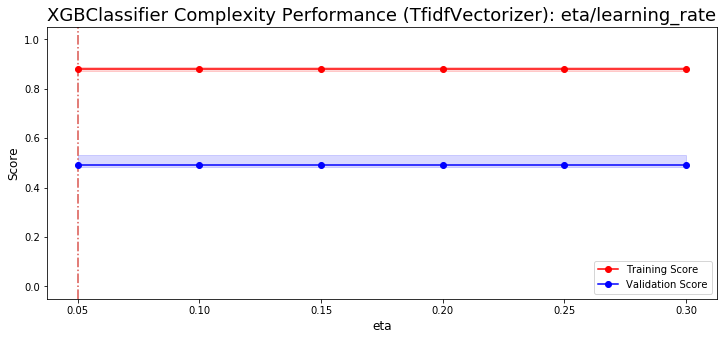

In [51]:
eta=np.array([0.05, 0.10, 0.15, 0.20, 0.25, 0.30])
title='XGBClassifier Complexity Performance (TfidfVectorizer): eta/learning_rate'
plot_val_curve(train_scores,test_scores,'eta', eta,title,logx=False)

In [ ]:
X=train_vec
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
gamma=np.array([0.0, 0.1, 0.2 , 0.3, 0.4])
train_scores, test_scores = validation_curve(XGBClassifier(), X, y, param_name = 'gamma', param_range = gamma, cv = cv, scoring = 'accuracy')

In [52]:
## Models were trained in HPC and output scores are uploaded here.
## Personalized_Medicine_TfidfVectorizer_XGBClassifier_gamma.py
train_scores=pd.read_csv(os.path.join(base_dir,'ml_result/Personalized_Medicine_TfidfVectorizer_XGBClassifier_gamma_train_scores_df.csv'))
test_scores=pd.read_csv(os.path.join(base_dir,'ml_result/Personalized_Medicine_TfidfVectorizer_XGBClassifier_gamma_test_scores_df.csv'))

gamma: [0.  0.1 0.2 0.3 0.4]
train_mean: [0.87967617 0.88020421 0.87952585 0.88013056 0.87990329]
test_mean: [0.49157096 0.49277708 0.48798678 0.49399291 0.49308601]
--------------------------------------------------------------------------------
gamma: 0.3 achieves highest test score: 0.49399291441300874
--------------------------------------------------------------------------------


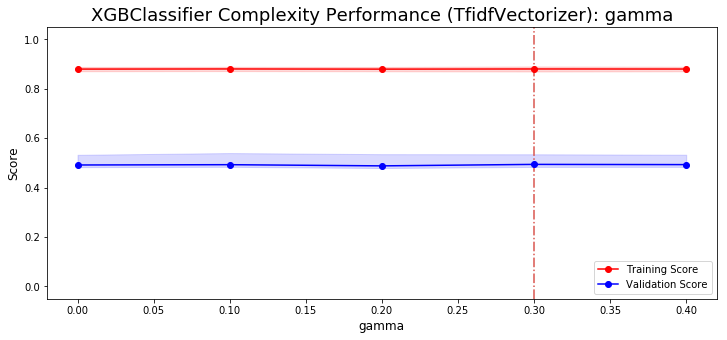

In [53]:
gamma=np.array([0.0, 0.1, 0.2 , 0.3, 0.4])
title='XGBClassifier Complexity Performance (TfidfVectorizer): gamma'
plot_val_curve(train_scores,test_scores,'gamma', gamma,title,logx=False)

In [ ]:
X=train_vec
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
colsample_bytree=np.array([0.2, 0.4, 0.6, 0.8, 1.0])
train_scores, test_scores = validation_curve(XGBClassifier(), X, y, param_name = 'colsample_bytree', param_range = colsample_bytree, cv = cv, scoring = 'accuracy')

In [54]:
## Models were trained in HPC and output scores are uploaded here.
## Personalized_Medicine_TfidfVectorizer_XGBClassifier_colsamplebytree.py
train_scores=pd.read_csv(os.path.join(base_dir,'ml_result/Personalized_Medicine_TfidfVectorizer_XGBClassifier_colsamplebytree_train_scores_df.csv'))
test_scores=pd.read_csv(os.path.join(base_dir,'ml_result/Personalized_Medicine_TfidfVectorizer_XGBClassifier_colsamplebytree_test_scores_df.csv'))

colsample_bytree: [0.2 0.4 0.6 0.8 1. ]
train_mean: [0.87552835 0.87673709 0.87824382 0.87930049 0.87967617]
test_mean: [0.49733674 0.49220548 0.48919484 0.48949732 0.49157096]
--------------------------------------------------------------------------------
colsample_bytree: 0.2 achieves highest test score: 0.497336740799888
--------------------------------------------------------------------------------


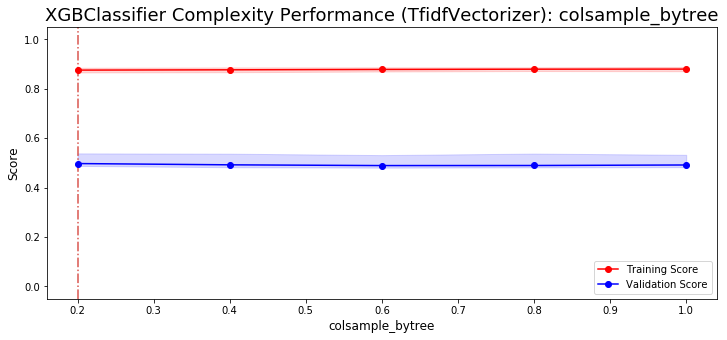

In [55]:
colsample_bytree=np.array([0.2, 0.4, 0.6, 0.8, 1.0])
title='XGBClassifier Complexity Performance (TfidfVectorizer): colsample_bytree'
plot_val_curve(train_scores,test_scores,'colsample_bytree', colsample_bytree,title,logx=False)

**Conclusion**:
1. The overall validation accuracy is higher using XGBClassifier.
2. XGBClassifier performance is not affected by hyperparameters tested here.

<a id='Part2.3.3.2_link'></a>
### 2.3.3.2 GridSearchCV

To further finetune the best values for hyperparameters, I will use **GridSearchCV** from sklearn.

In [ ]:
## Models were trained in HPC and output scores are uploaded here.
## Personalized_Medicine_TfidfVectorizer_XGBClassifier_gridsearch1.py
xgb=XGBClassifier()
X=train_vec
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
params={"eta":[0.05, 0.20, 0.30],
        "max_depth":[6],
        "min_child_weight":[ 1, 5, 10 ],
        "gamma":[0.0, 0.2, 0.4],
        "colsample_bytree":[0.2, 0.6, 1.0]}
clf=GridSearchCV(xgb, param_grid=params, cv=cv, scoring = 'accuracy',return_train_score=True)
clf.fit(X, y)
pd.DataFrame.from_dict(clf.cv_results_).to_csv(os.path.join(base_dir,'ml_result3/Personalized_Medicine_TfidfVectorizer_XGBClassifier_gridsearch1.csv'),index=False)

In [ ]:
print("eta: {}".format(clf.best_estimator_.get_params()['eta']))
print("max_depth: {}".format(clf.best_estimator_.get_params()['max_depth']))
print("min_child_weight: {}".format(clf.best_estimator_.get_params()['min_child_weight']))
print("gamma: {}".format(clf.best_estimator_.get_params()['gamma']))
print("colsample_bytree: {}".format(clf.best_estimator_.get_params()['colsample_bytree']))

eta: 0.05
<br>max_depth: 6
<br>min_child_weight: 5
<br>gamma: 0.4
<br>colsample_bytree: 0.2

In [67]:
cv_results=pd.read_csv(os.path.join(base_dir,'ml_result3/Personalized_Medicine_TfidfVectorizer_XGBClassifier_gridsearch1.csv'))
cv_results[(cv_results.param_eta==0.05) & (cv_results.param_max_depth==6) & (cv_results.param_min_child_weight==5)]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_eta,param_gamma,param_max_depth,param_min_child_weight,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
1,252.220196,2.375948,0.518739,0.016992,0.2,0.05,0.0,6,5,"{'colsample_bytree': 0.2, 'eta': 0.05, 'gamma'...",...,0.494572,0.040023,13,0.898036,0.912075,0.912962,0.895669,0.895371,0.902823,0.007975
4,251.320244,2.847936,0.508028,0.019682,0.2,0.05,0.2,6,5,"{'colsample_bytree': 0.2, 'eta': 0.05, 'gamma'...",...,0.493366,0.049132,19,0.897659,0.911698,0.912962,0.895292,0.895371,0.902596,0.008003
7,392.262332,4.535713,0.890483,0.043404,0.2,0.05,0.4,6,5,"{'colsample_bytree': 0.2, 'eta': 0.05, 'gamma'...",...,0.500905,0.043532,1,0.898036,0.911698,0.912962,0.896045,0.895371,0.902822,0.007822
28,988.376284,150.365583,0.791403,0.159174,0.6,0.05,0.0,6,5,"{'colsample_bytree': 0.6, 'eta': 0.05, 'gamma'...",...,0.489144,0.049290,31,0.898036,0.912075,0.912962,0.895669,0.895747,0.902898,0.007906
31,923.918271,181.910857,0.645532,0.164310,0.6,0.05,0.2,6,5,"{'colsample_bytree': 0.6, 'eta': 0.05, 'gamma'...",...,0.494572,0.046279,13,0.897281,0.912075,0.912962,0.896422,0.895747,0.902897,0.007876
34,709.851518,6.798951,0.506156,0.021060,0.6,0.05,0.4,6,5,"{'colsample_bytree': 0.6, 'eta': 0.05, 'gamma'...",...,0.490953,0.043692,28,0.898036,0.911698,0.912962,0.896045,0.896123,0.902973,0.007684
55,945.597628,27.323084,0.427098,0.046627,1.0,0.05,0.0,6,5,"{'colsample_bytree': 1.0, 'eta': 0.05, 'gamma'...",...,0.487033,0.044838,40,0.898414,0.912075,0.912585,0.896045,0.895747,0.902973,0.007697
58,950.545306,9.108575,0.411836,0.015454,1.0,0.05,0.2,6,5,"{'colsample_bytree': 1.0, 'eta': 0.05, 'gamma'...",...,0.481906,0.052212,61,0.898036,0.912075,0.912585,0.896422,0.895747,0.902973,0.007678
61,951.953345,11.139883,0.412409,0.020066,1.0,0.05,0.4,6,5,"{'colsample_bytree': 1.0, 'eta': 0.05, 'gamma'...",...,0.481906,0.048535,61,0.898414,0.912075,0.912962,0.895669,0.895747,0.902973,0.007861


<a id='Part2.3.3.3_link'></a>
### 2.3.3.3 Model evaluation

* Model: XGBClassifier(eta=0.05,max_depth=6,min_child_weight=5,gamma=0.4,colsample_bytree=0.2)

In [68]:
X=train_vec
y=train_df.Class.values
clf=XGBClassifier(eta=0.05,max_depth=6,min_child_weight=5,gamma=0.4,colsample_bytree=0.2,n_jobs=-1,random_state=8)

In [69]:
output=model_eval(clf, X, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  6.8min remaining: 10.1min


accuracy score: 0.49728588661037393
log_loss: 1.6046026622444285


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.9min finished


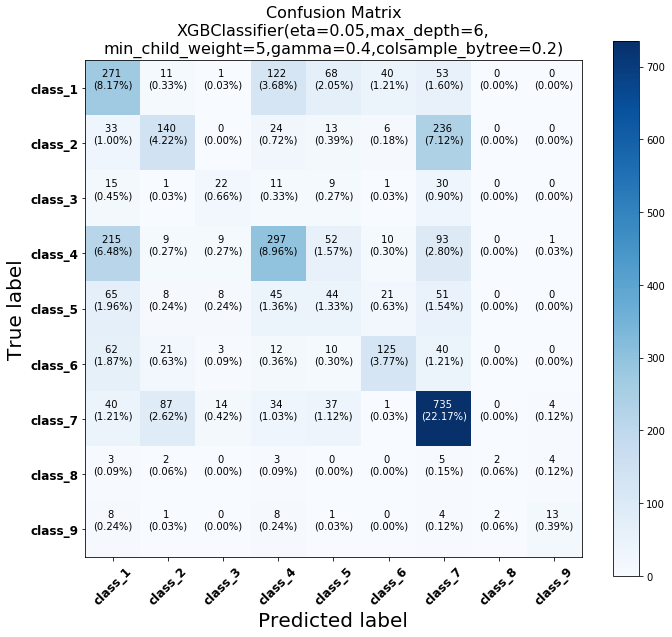

In [73]:
cm = confusion_matrix(train_df.Class.values, output.pred)
classes = ['class_{}'.format(i) for i in range(1,10)]
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix\nXGBClassifier(eta=0.05,max_depth=6,\nmin_child_weight=5,gamma=0.4,colsample_bytree=0.2)', cmap=plt.cm.Blues)

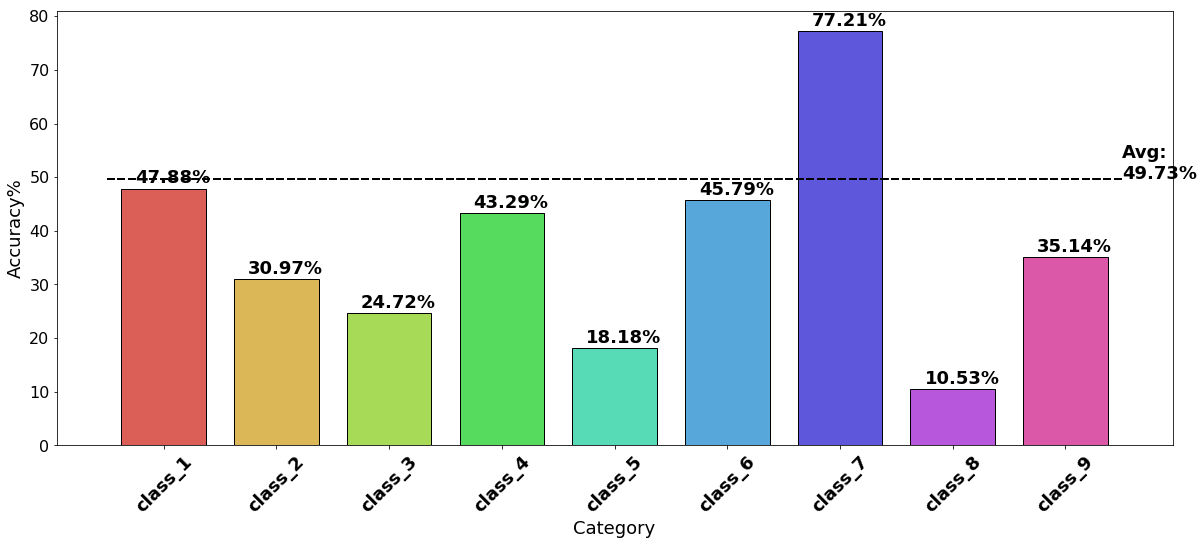

In [71]:
plot_acc_bar(cm,total_acc=49.73)

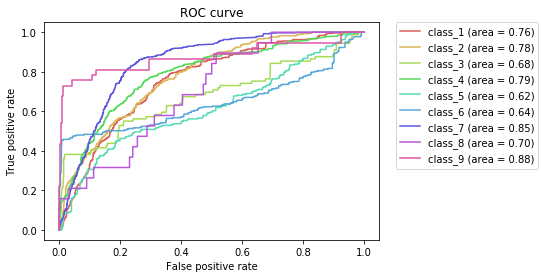

In [72]:
plot_ROC_curve(output)

<a id='Part2.3.3.4_link'></a>
### 2.3.3.4 Feature importance

We can extract the features (words) with high importance from the trained model.

* Model: XGBClassifier(eta=0.05,max_depth=6,min_child_weight=5,gamma=0.4,colsample_bytree=0.2)

In [74]:
X=train_vec
y=train_df.Class.values
clf=XGBClassifier(eta=0.05,max_depth=6,min_child_weight=5,gamma=0.4,colsample_bytree=0.2,n_jobs=-1,random_state=8)
clf.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.2, eta=0.05, gamma=0.4, learning_rate=0.1,
              max_delta_step=0, max_depth=6, min_child_weight=5, missing=None,
              n_estimators=100, n_jobs=-1, nthread=None,
              objective='multi:softprob', random_state=8, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=1)

In [76]:
top_features=extract_feature_importance_rf(clf,tfidf_vectorizer,n=20)
top_features

,words,importance
0,ivs2,0.018359
1,ivs20,0.013292
2,ivs5,0.010199
3,brca,0.008228
4,1jm7,0.008071
5,pten,0.007757
6,helicase,0.006713
7,trans,0.006618
8,nhgri,0.006545
9,2071883699,0.005362


**Conclusion for XGBClassifier**: 
<br>XGBClassifier(eta=0.05,max_depth=6,min_child_weight=5,gamma=0.4,colsample_bytree=0.2) achieves the highest accuracy score of 0.50.

## Conclusion for TfidfVectorizer:

1. The overall training performance is comparable between **CountVectorizer** and **TfidfVectorizer**.
2. Machine learning models **LogisticRegression**, **RandomForestClassifier** and **XGBClassifier** applied to **TfidfVectorizer** cannot achieve accuracy above 0.50.
3. **RandomForestClassifier** and **XGBClassifier** achieve comparable training performance and the accuracy score is higher than **LogisticRegression**.
4. XGBClassifier(eta=0.05,max_depth=6,min_child_weight=5,gamma=0.4,colsample_bytree=0.2) achieves the highest accuracy score of 0.50.